In [1]:
import json 
from dataclasses import dataclass 
import pandas as pd 
import matplotlib.pyplot as plt 

In [4]:
@dataclass
class ModelData:
    model_name: str 
    model_path: str 
    is_instr: bool 
    is_reinit: bool 
    is_full: bool 
    model_size: str 
    prediction: str 
    label: str 
    correct: bool 
    qlora: bool 

In [5]:
def check_score(text, label):
    other_label = '0' if label == '1' else '1'
    label_char = 'A' if label == '0' else 'B'
    other_label_char = 'B' if label == '0' else 'A'
    if (text[0] == 'A') and (label == '0'):
        return 1
    if (text[0] == 'B') and (label == '1'):
        return 1
    if f'{label}.' in text or f' {label}' in text.lower() or f'{label}' == text.strip() or f'\n{label}' in text.lower() or text.startswith(label) or text.strip().startswith(label_char):
        return 1
    elif f'{other_label}.' in text or f' {other_label}' in text.lower() or f'{other_label}' == text.strip() or f'\n{other_label}' in text.lower() or text.startswith(other_label) or text.strip().startswith(other_label_char):
        return 0
    elif str(label) == '0':
        if 'A.' in text:
            return 1 
    elif str(label) == '1':
        if 'B.' in text:
            return 1
    return None


In [75]:
models = ['llama-3.1-8b', 'llama-3.2-1b', 'qlora-llama-3.1-8b', 'qlora-llama-3.2-1b', 'qlora-llama-3.2-3b-instruct','qlora-llama-3.1-8b-instruct', 'qlora-llama-3.1-3b-instruct-full', '3b_qlora_single_device_instruct-reinit', 'llama-3.2-1b-instruct','llama-3.2-3b', 'llama-3.2-3b-instruct','llama-3.2-8b-instruct', 'qlora-llama-3.2-1b-instruct', 'qlora-llama-3.2-3b']

model_name_mapping = {
    'qlora-llama-3.1-8b-instruct': 'llama-3.1-8b',
    'qlora-llama-3.1-3b-instruct-full': 'llama-3.2-3b',
    'qlora-llama-3.2-1b': 'llama-3.2-1b',
    'qlora-llama-3.2-3b-instruct': 'llama-3.2-3b',
    '3b_qlora_single_device_instruct-reinit': 'llama-3.2-3b',
    'qlora-llama-3.1-8b-instruct': 'llama-3.1-8b',
    'qlora-llama-3.1-3b-instruct-full': 'llama-3.2-3b',
    'llama-3.1-8b': 'llama-3.1-8b',
    'llama-3.2-3b': 'llama-3.2-3b',
    'llama-3.2-1b': 'llama-3.2-1b',
    'qlora-llama-3.1-8b': 'llama-3.1-8b',
    'llama-3.2-8b-instruct': 'llama-3.1-8b',
    'llama-3.2-1b-instruct': 'llama-3.2-1b',
    'llama-3.2-3b-instruct': 'llama-3.2-3b',
    'qlora-llama-3.2-1b-instruct': 'llama-3.2-1b',
    'qlora-llama-3.2-3b': 'llama-3.2-3b',
}


model_size_mapping = {
    'llama-3.1-8b': 8,
    'llama-3.2-1b': 1,
    'llama-3.2-3b': 3,
}

test_name = 'test.json'

data_list = []
for model in models:
    with open(f'../train_data/predictions/{model}/{test_name}', 'r') as f:
        data = json.load(f)
        for text, label in zip(data['predictions'], data['labels']):
            label = str(label)
            if model == '3b_qlora_single_device_instruct-reinit':
                is_reinit = True
                qlora = True
                is_instr = True
            elif model == 'qlora-llama-3.1-3b-instruct-full':
                is_full = True
                qlora = True
            else:
                is_reinit = False
                is_full = False
                qlora = 'qlora' in model
            model_name = model_name_mapping[model]  
            model_size = model_size_mapping[model_name]
            data_list.append(ModelData(model_name=model_name, model_path=model, is_instr=model.endswith('instruct'), model_size=model_size, prediction=text, label=label, correct=check_score(text, label), is_reinit=is_reinit, is_full=is_full, qlora=qlora))




In [76]:
keys = ['model_name', 'is_instr', 'is_reinit', 'is_full']
# model size effect 

In [77]:
df = pd.DataFrame(data_list)
df['correct'] = df['correct'].fillna('none')
only_ans = df[df['correct']!='none']

In [78]:
df['is_error'] = df['correct'] == 'none'
print(df[(df['qlora'] == False) & (df['is_full'] == False) & (df['is_reinit'] == False)].groupby(['model_name','is_instr'])['is_error'].mean().reset_index().pivot(index='model_name', columns = 'is_instr').to_latex())

\begin{tabular}{lrr}
\toprule
 & \multicolumn{2}{r}{is_error} \\
is_instr & False & True \\
model_name &  &  \\
\midrule
llama-3.1-8b & 0.000000 & 0.740000 \\
llama-3.2-1b & 0.000000 & 0.295000 \\
llama-3.2-3b & 0.000000 & 0.000000 \\
\bottomrule
\end{tabular}



In [79]:
# Add this code to your notebook
result_df = df[(df['qlora'] == False) & (df['is_full'] == False) & (df['is_reinit'] == False)].groupby(['model_name','is_instr'])['is_error'].mean().reset_index().pivot(index='model_name', columns = 'is_instr')
html_table = result_df.to_html()

# Save to a file
with open('table_for_google_docs.html', 'w') as f:
    f.write(html_table)

In [80]:
df['model_path'] = df['model_path'].apply(lambda x: 'llama-3.1-8b-instruct' if x == 'llama-3.2-8b-instruct' else x)

In [81]:
df

,model_name,model_path,is_instr,is_reinit,is_full,model_size,prediction,label,correct,qlora,is_error
0,llama-3.1-8b,llama-3.1-8b,False,False,False,8,B\n,0,0.0,False,False
1,llama-3.1-8b,llama-3.1-8b,False,False,False,8,A\nExplanation: The on the information provid...,0,1.0,False,False
2,llama-3.1-8b,llama-3.1-8b,False,False,False,8,"B.Explanation: The person is a42 years old, w...",1,1.0,False,False
3,llama-3.1-8b,llama-3.1-8b,False,False,False,8,B\nExplanation: The person yearly income is a...,0,1.0,False,False
4,llama-3.1-8b,llama-3.1-8b,False,False,False,8,B\n,1,1.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...
2795,llama-3.2-3b,qlora-llama-3.2-3b,False,False,False,3,0,0,1.0,True,False
2796,llama-3.2-3b,qlora-llama-3.2-3b,False,False,False,3,0,0,1.0,True,False
2797,llama-3.2-3b,qlora-llama-3.2-3b,False,False,False,3,0,0,1.0,True,False
2798,llama-3.2-3b,qlora-llama-3.2-3b,False,False,False,3,0,0,1.0,True,False


In [82]:
df.groupby(['label'])['label'].count()

label
0    1876
1     924
Name: label, dtype: int64

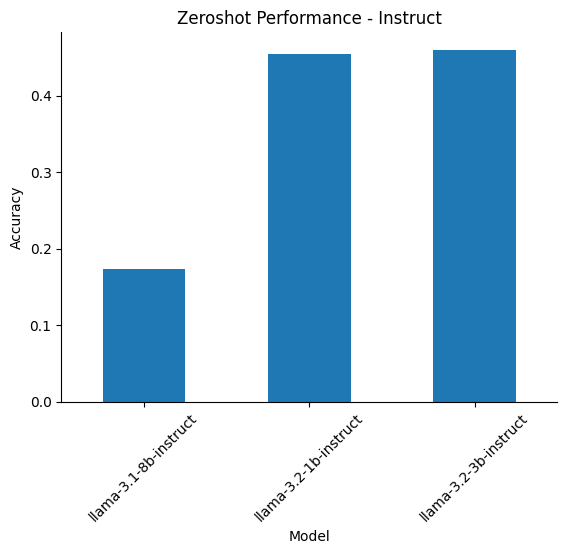

In [83]:
# zeroshot performance base
fig, ax = plt.subplots()
zero_shot = df[(df['is_instr']==True) & (df['qlora']==False)]
zero_shot = zero_shot[zero_shot['correct']!='none']
zero_shot.groupby(['model_path'])['correct'].mean().plot(kind='bar', ax=ax)
ax.set_title('Zeroshot Performance - Instruct')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('../plots/zeroshot_instruct.jpg', dpi=300, bbox_inches='tight')
plt.show()



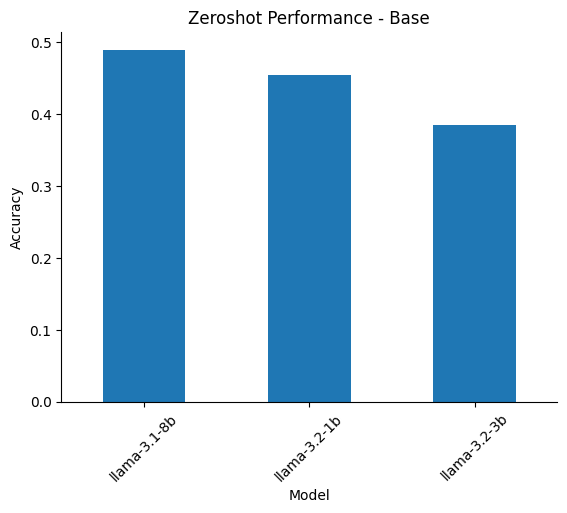

In [84]:
# zeroshot performance base
fig, ax = plt.subplots()

zero_shot = df[(df['is_instr']==False) & (df['is_full']==False) & (df['is_reinit']==False) & (df['qlora']==False)]
zero_shot.groupby(['model_path'])['correct'].mean().plot(kind='bar', ax=ax)
ax.set_title('Zeroshot Performance - Base')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('../plots/zeroshot_base.jpg', dpi=300, bbox_inches='tight')
plt.show()


In [85]:
is_instr = df[(df['is_instr']==True) & (df['is_full']==False) & (df['is_reinit']==False) & (df['qlora']==True)]

<Axes: xlabel='model_name'>

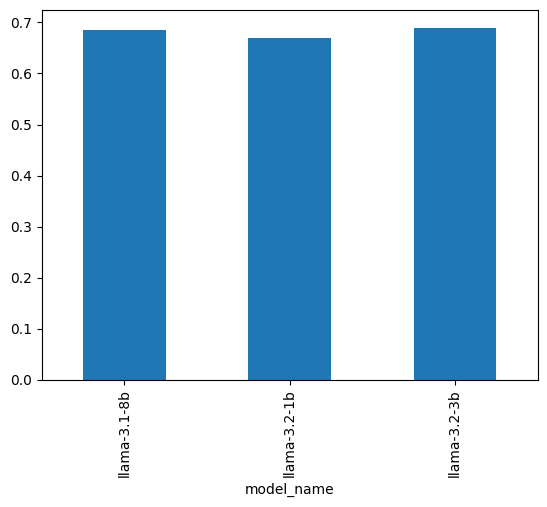

In [86]:
is_instr.groupby(['model_name'])['correct'].mean().plot(kind='bar')

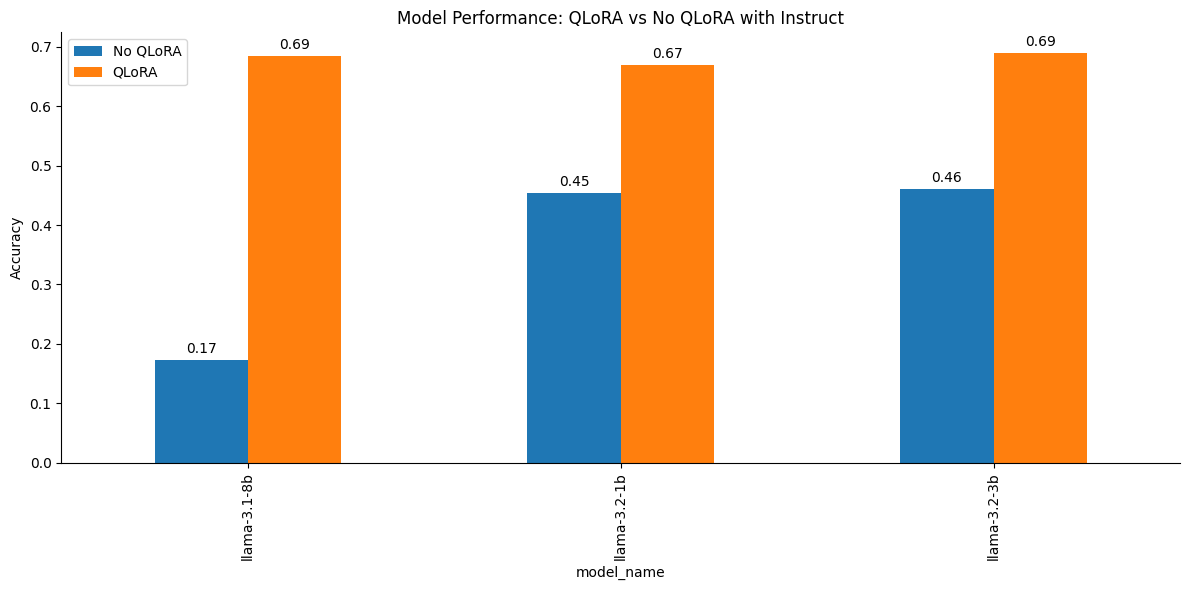

In [87]:
# qlora_vs_no_qlora = df[(df['is_instr']==True) & (df['is_full']==False) & (df['is_reinit']==False)]
# qlora_vs_no_qlora = qlora_vs_no_qlora[qlora_vs_no_qlora['correct']!='none']
# qlora_vs_no_qlora.groupby(['model_path','qlora'])['correct'].mean().plot(kind='bar')
qlora_vs_no_qlora = df[(df['is_instr']==True) & (df['is_full']==False) & (df['is_reinit']==False)]
qlora_vs_no_qlora = qlora_vs_no_qlora[qlora_vs_no_qlora['correct']!='none']

# Group by model_path and qlora, then calculate mean of 'correct'
grouped_data = qlora_vs_no_qlora.groupby(['model_name', 'qlora'])['correct'].mean().unstack()

# Create a bar chart with side-by-side bars for each model
ax = grouped_data.plot(kind='bar', figsize=(12, 6))

# Customize the chart
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance: QLoRA vs No QLoRA with Instruct')
ax.legend(['No QLoRA', 'QLoRA'] if False in grouped_data.columns else ['QLoRA'])

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('../plots/qlora_vs_no_qlora.jpg', dpi=300, bbox_inches='tight')
plt.show()


In [88]:
df[df['model_name']=='llama-3.2-3b']

,model_name,model_path,is_instr,is_reinit,is_full,model_size,prediction,label,correct,qlora,is_error
800,llama-3.2-3b,qlora-llama-3.2-3b-instruct,True,False,False,3,0,0,1.0,True,False
801,llama-3.2-3b,qlora-llama-3.2-3b-instruct,True,False,False,3,0,0,1.0,True,False
802,llama-3.2-3b,qlora-llama-3.2-3b-instruct,True,False,False,3,1,1,1.0,True,False
803,llama-3.2-3b,qlora-llama-3.2-3b-instruct,True,False,False,3,1,0,0.0,True,False
804,llama-3.2-3b,qlora-llama-3.2-3b-instruct,True,False,False,3,0,1,0.0,True,False
...,...,...,...,...,...,...,...,...,...,...,...
2795,llama-3.2-3b,qlora-llama-3.2-3b,False,False,False,3,0,0,1.0,True,False
2796,llama-3.2-3b,qlora-llama-3.2-3b,False,False,False,3,0,0,1.0,True,False
2797,llama-3.2-3b,qlora-llama-3.2-3b,False,False,False,3,0,0,1.0,True,False
2798,llama-3.2-3b,qlora-llama-3.2-3b,False,False,False,3,0,0,1.0,True,False


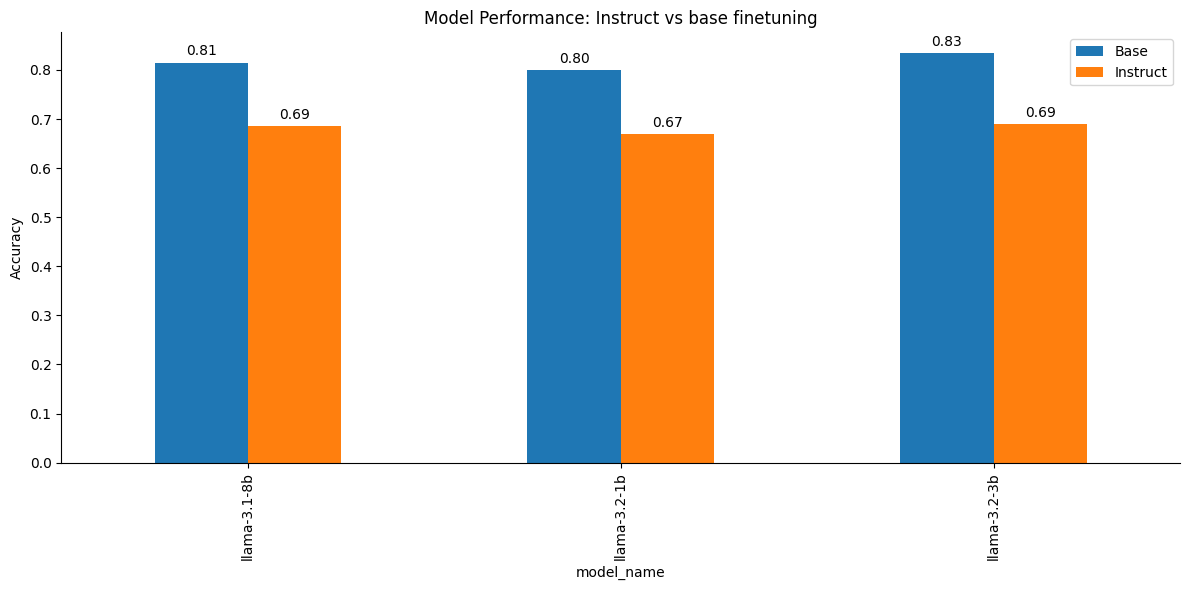

In [89]:
base_it = df[(df['qlora']==True) & (df['is_full']==False) & (df['is_reinit']==False)]
base_it = base_it[base_it['correct']!='none']



# Group by model_path and qlora, then calculate mean of 'correct'
grouped_data = base_it.groupby(['model_name','is_instr'])['correct'].mean().unstack()

# Create a bar chart with side-by-side bars for each model
ax = grouped_data.plot(kind='bar', figsize=(12, 6))

# Customize the chart
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance: Instruct vs base finetuning')
ax.legend(['Base', 'Instruct'] if False in grouped_data.columns else ['Instruct'])

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('../plots/instr_vs_not_instr.jpg', dpi=300, bbox_inches='tight')
plt.show()



In [55]:
# full vs not full
full_mean = df[df['is_full'] == True]['correct'].mean()
not_full_mean = df[(df['is_full'] == False) & (df['is_instr']==True) & (df['qlora']==True) & (df['is_reinit']==False) & (df['model_size']==3)]['correct'].mean()

In [34]:
print(f'Full mean: {full_mean}, Not full mean: {not_full_mean}')

Full mean: 0.6175, Not full mean: 0.69


In [90]:
df[df['is_reinit'] == True]['correct'].mean()

0.585

In [91]:
df[(df['is_reinit'] == False) & (df['is_full'] == False) & (df['is_instr'] == True) & (df['qlora'] == True) & (df['model_size'] == 3)]['correct'].mean()

0.69

logits? 

In [ ]:

test_name = 'test_logits.json'

data_list = []
for model in models:
    with open(f'../train_data/predictions/{model}/{test_name}', 'r') as f:
        data = json.load(f)
        for text, label in zip(data['predictions'], data['labels']):
            label = str(label)
            if model == '3b_qlora_single_device_instruct-reinit':
                is_reinit = True
                qlora = True
                is_instr = True
            elif model == 'qlora-llama-3.1-3b-instruct-full':
                is_full = True
                qlora = True
            else:
                is_reinit = False
                is_full = False
                qlora = 'qlora' in model
            model_name = model_name_mapping[model]  
            model_size = model_size_mapping[model_name]
            data_list.append(ModelData(model_name=model_name, model_path=model, is_instr=model.endswith('instruct'), model_size=model_size, prediction=text, label=label, correct=check_score(text, label), is_reinit=is_reinit, is_full=is_full, qlora=qlora))


